## Building Footprint Data
Loading bounding coordinates of buildings in the area.

In [17]:
import pandas as pd
import xml.etree.ElementTree as ET

def read_kml(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    
    ns = {'kml': 'http://www.opengis.net/kml/2.2'}
    
    data = []
    for placemark in root.findall('.//kml:Placemark', ns):
        building = {}
        
        # Get all SimpleData fields
        for simple_data in placemark.findall('.//kml:SimpleData', ns):
            name = simple_data.get('name')
            value = simple_data.text
            building[name] = value
            
        # Get coordinates
        coords_elem = placemark.find('.//kml:coordinates', ns)
        if coords_elem is not None:
            coords_text = coords_elem.text.strip()
            # Store raw coordinates string
            building['coordinates'] = coords_text
            
            # Calculate centroid (average of all coordinates)
            coords = []
            for coord in coords_text.split():
                lon, lat = map(float, coord.split(',')[:2])
                coords.append((lon, lat))
            
            # Add centroid as separate columns
            if coords:
                building['longitude'] = sum(c[0] for c in coords) / len(coords)
                building['latitude'] = sum(c[1] for c in coords) / len(coords)
        
        data.append(building)
    
    # Convert to DataFrame
    df = pd.DataFrame(data)
    
    # Convert numeric columns
    numeric_columns = ['fid', 'tessellate', 'extrude', 'visibility']
    for col in numeric_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='ignore')
            
    return df

# Example usage
kml_file = "../data/Building_Footprint.kml"  # Make sure this path is correct
buildings_df = read_kml(kml_file)

/var/folders/fg/gtyh9bm95ssfs2_k2xlfk2d80000gp/T/ipykernel_33795/409316873.py:47: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')


Location Identifiers:

* id: Unique identifier (e.g., "cugir009034.3") for each building footprint
* fid: A numeric ID (like 7624, 7625, etc.)
* layer: Always "clip_Bronx" in this dataset, indicating these are buildings in the Bronx area
* path: The original file path where this data was processed from


Geometric Properties:

* coordinates: Raw string of longitude/latitude pairs that define the building's polygon outline
* longitude: Calculated center point (centroid) longitude of the building
* latitude: Calculated center point (centroid) latitude of the building


Rendering Properties:

* tessellate (-1): Controls whether the geometry should follow the terrain
* extrude (0): Controls whether the geometry should be extended down to the ground
* visibility (-1): Controls whether the feature is initially visible

In [14]:
import xml.etree.ElementTree as ET
import folium

def parse_coordinates(coord_str):
    # Split coordinates into pairs and convert to float
    coords = []
    pairs = coord_str.strip().split(' ')
    for pair in pairs:
        if pair:
            lon, lat = pair.split(',')[:2]  # Take only first two values
            coords.append([float(lat), float(lon)])  # Folium uses [lat, lon]
    return coords

def read_and_plot_kml(file_path):
    # Parse KML
    tree = ET.parse(file_path)
    root = tree.getroot()
    
    # Create map centered on approximate middle of NYC
    m = folium.Map(location=[40.785, -73.95], zoom_start=13)
    
    # Define namespace
    ns = {'kml': 'http://www.opengis.net/kml/2.2'}
    
    # Find all coordinate sets
    for coords in root.findall('.//kml:coordinates', ns):
        coord_list = parse_coordinates(coords.text)
        if coord_list:
            # Create polygon for each building
            folium.Polygon(
                locations=coord_list,
                color='blue',
                fill=True,
                weight=1
            ).add_to(m)
    
    # Save map
    m.save('building_footprints.html')

# Use the function
kml_file = "../data/Building_Footprint.kml"  # Adjust path as needed
read_and_plot_kml(kml_file)

## NY Mesonet Weather Data
### Background

This spreadsheet contains detailed weather data provided by the New York State Mesonet. There are two datasets (see worksheet tabs) located in the Bronx (Latitude=40.87248, Longitude=-73.89352, Altitude=57.5 meters) and Manhattan (Latitude = 40.76754, Longitude = -73.96449, Altitude = 94.8 meters). These two weather stations are located at the southern and northern ends of the ground traverse data (see "Location" tab). The data was collected near the surface (2-meters height) every 5 minutes during the day. This data may be useful for your AI model as it contains air temperature, wind speed and direction, and solar isolation (solar flux at the surface). 

### How might you use this data?

* Temperature and Relative Humidity - These data were collected by the sensor at 2-meters height, near the ground. Since these data points are not part of the core challenge dataset, they should only be used for reference. As a note, when temperature is combined with relative humidity, it yields a "heat index" which is the apparent temperature experienced by the human body. High values of "heat index" have been known to contribute to health issues. 

* Wind Speed and Direction - It may be possible to use this information in your model. For example, wind speed and direction may impact the local mixing of air at the surface depending on local building geometries. Such variations in air mixing could impact local urban heating conditions. 

* Solar Flux - It may be possible to use this information in your model. For example, solar flux is the amount of solar energy that reaches the ground which is impacted by cloud cover and building shading. When combined with building footprint, building height, and sun angle data, it may be possible to predict the shading conditions for specific locations on the ground. Such information could impact local urban heating conditions. 

### How was temperature data collected for this challenge?

The core temperature data for this challenge was collected using ground traverses in cars. The data was collected in the afternoon from 3:00pm to 4:00pm. The data was then converted to a UHI index using the actual temperature at any location divided by the mean temperature of the dataset. 





In [21]:
import pandas as pd

def load_weather_data(file_path):
    # Read specific sheets
    bronx_df = pd.read_excel(file_path, sheet_name='Bronx')
    manhattan_df = pd.read_excel(file_path, sheet_name='Manhattan')
    
    # Convert Date/Time column to datetime
    bronx_df['Date / Time'] = pd.to_datetime(bronx_df['Date / Time'])
    manhattan_df['Date / Time'] = pd.to_datetime(manhattan_df['Date / Time'])
    
    # Display basic info about each dataframe
    print("Bronx DataFrame:")
    print("\nShape:", bronx_df.shape)
    
    print("\nManhattan DataFrame:")
    print("\nShape:", manhattan_df.shape)
    
    return bronx_df, manhattan_df

# Load the data
excel_file = "../data/NY_Mesonet_Weather.xlsx" 
bronx_df, manhattan_df = load_weather_data(excel_file)

Bronx DataFrame:

Shape: (169, 6)

Manhattan DataFrame:

Shape: (169, 6)


/var/folders/fg/gtyh9bm95ssfs2_k2xlfk2d80000gp/T/ipykernel_33795/2847187931.py:9: FutureWarning: Parsed string "2021-07-24 06:00:00 EDT" included an un-recognized timezone "EDT". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  bronx_df['Date / Time'] = pd.to_datetime(bronx_df['Date / Time'])
/var/folders/fg/gtyh9bm95ssfs2_k2xlfk2d80000gp/T/ipykernel_33795/2847187931.py:10: FutureWarning: Parsed string "2021-07-24 06:00:00 EDT" included an un-recognized timezone "EDT". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  manhattan_df['Date / Time'] = pd.to_datetime(manhattan_df['Date / Time'])


In [23]:
bronx_df.info()
manhattan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Date / Time                  169 non-null    datetime64[ns]
 1   Air Temp at Surface [degC]   169 non-null    float64       
 2   Relative Humidity [percent]  169 non-null    float64       
 3   Avg Wind Speed [m/s]         169 non-null    float64       
 4   Wind Direction [degrees]     169 non-null    int64         
 5   Solar Flux [W/m^2]           169 non-null    int64         
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 8.1 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Date / Time                  169 non-null    datetime64[ns]
 1   Air

In [31]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

def calculate_building_metrics(buildings_df):
    """
    Calculate additional metrics for building analysis
    """
    metrics = []
    
    for _, building in buildings_df.iterrows():
        # Convert coordinates string to polygon
        coords_str = building['coordinates']
        coords_list = [tuple(map(float, coord.split(',')[:2])) 
                      for coord in coords_str.split()]
        polygon = Polygon(coords_list)
        
        # Calculate metrics
        metrics.append({
            'fid': building['fid'],
            'area': polygon.area,  # in coordinate units
            'perimeter': polygon.length,
            'compactness': 4 * np.pi * polygon.area / (polygon.length ** 2),
            'longitude': building['longitude'],
            'latitude': building['latitude']
        })
    
    return pd.DataFrame(metrics)

def analyze_temperature_variations(bronx_df, manhattan_df):
    """
    Analyze temperature variations between Bronx and Manhattan locations
    """
    # Calculate heat index using simplified formula
    def heat_index(T, RH):
        T_fahrenheit = T * 9/5 + 32  # Convert to Fahrenheit
        return -42.379 + 2.04901523*T_fahrenheit + 10.14333127*RH - \
               0.22475541*T_fahrenheit*RH - 6.83783e-3*T_fahrenheit**2 - \
               5.481717e-2*RH**2 + 1.22874e-3*T_fahrenheit**2*RH + \
               8.5282e-4*T_fahrenheit*RH**2 - 1.99e-6*T_fahrenheit**2*RH**2

    # Process both dataframes
    for df in [bronx_df, manhattan_df]:
        df['heat_index'] = heat_index(
            df['Air Temp at Surface [degC]'],
            df['Relative Humidity [percent]']
        )
    
    # Calculate hourly statistics for both locations
    bronx_hourly = bronx_df.resample('H', on='Date / Time').agg({
        'Air Temp at Surface [degC]': ['mean', 'min', 'max'],
        'heat_index': ['mean', 'min', 'max'],
        'Solar Flux [W/m^2]': 'mean',
        'Avg Wind Speed [m/s]': 'mean',
        'Wind Direction [degrees]': 'mean'
    })

    manhattan_hourly = manhattan_df.resample('H', on='Date / Time').agg({
        'Air Temp at Surface [degC]': ['mean', 'min', 'max'],
        'heat_index': ['mean', 'min', 'max'],
        'Solar Flux [W/m^2]': 'mean',
        'Avg Wind Speed [m/s]': 'mean',
        'Wind Direction [degrees]': 'mean'
    })
    
    # Calculate temperature differences
    temp_diff = pd.DataFrame({
        'temp_difference': bronx_hourly['Air Temp at Surface [degC]']['mean'] - 
                          manhattan_hourly['Air Temp at Surface [degC]']['mean'],
        'heat_index_difference': bronx_hourly['heat_index']['mean'] - 
                                manhattan_hourly['heat_index']['mean']
    })
    
    return {
        'bronx_stats': bronx_hourly,
        'manhattan_stats': manhattan_hourly,
        'temperature_differences': temp_diff
    }

def analyze_urban_heat_patterns(buildings_metrics, weather_stats):
    """
    Analyze relationships between building characteristics and temperature patterns
    """
    # Normalize building metrics for comparison
    scaler = StandardScaler()
    normalized_metrics = pd.DataFrame(
        scaler.fit_transform(buildings_metrics[['area', 'perimeter', 'compactness']]),
        columns=['area_norm', 'perimeter_norm', 'compactness_norm']
    )
    
    # Calculate daily patterns for both locations
    bronx_daily = weather_stats['bronx_stats'].resample('D').mean()
    manhattan_daily = weather_stats['manhattan_stats'].resample('D').mean()
    
    # Identify heat islands (periods with significant temperature differences)
    temp_diff_std = weather_stats['temperature_differences']['temp_difference'].std()
    significant_diff_periods = weather_stats['temperature_differences'][
        abs(weather_stats['temperature_differences']['temp_difference']) > temp_diff_std
    ]
    
    return {
        'normalized_metrics': normalized_metrics,
        'bronx_daily': bronx_daily,
        'manhattan_daily': manhattan_daily,
        'significant_differences': significant_diff_periods
    }

def visualize_results(buildings_metrics, weather_stats, analysis_results):
    """
    Create visualizations comparing Bronx and Manhattan temperature patterns
    """
    fig = plt.figure(figsize=(20, 15))
    
    # Plot 1: Temperature comparison
    ax1 = plt.subplot(3, 2, 1)
    weather_stats['bronx_stats']['Air Temp at Surface [degC]']['mean'].plot(
        label='Bronx', ax=ax1)
    weather_stats['manhattan_stats']['Air Temp at Surface [degC]']['mean'].plot(
        label='Manhattan', ax=ax1)
    ax1.set_title('Temperature Comparison')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Temperature (°C)')
    ax1.legend()
    
    # Plot 2: Temperature difference distribution
    ax2 = plt.subplot(3, 2, 2)
    sns.histplot(data=weather_stats['temperature_differences']['temp_difference'], 
                bins=30, ax=ax2)
    ax2.set_title('Temperature Difference Distribution (Bronx - Manhattan)')
    ax2.set_xlabel('Temperature Difference (°C)')
    
    # Plot 3: Wind speed comparison
    ax3 = plt.subplot(3, 2, 3)
    weather_stats['bronx_stats']['Avg Wind Speed [m/s]'].plot(
        label='Bronx', ax=ax3)
    weather_stats['manhattan_stats']['Avg Wind Speed [m/s]'].plot(
        label='Manhattan', ax=ax3)
    ax3.set_title('Wind Speed Comparison')
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Wind Speed (m/s)')
    ax3.legend()
    
    # Plot 4: Heat index comparison
    ax4 = plt.subplot(3, 2, 4)
    weather_stats['bronx_stats']['heat_index']['mean'].plot(
        label='Bronx', ax=ax4)
    weather_stats['manhattan_stats']['heat_index']['mean'].plot(
        label='Manhattan', ax=ax4)
    ax4.set_title('Heat Index Comparison')
    ax4.set_xlabel('Time')
    ax4.set_ylabel('Heat Index')
    ax4.legend()
    
    # Plot 5: Solar flux comparison
    ax5 = plt.subplot(3, 2, 5)
    weather_stats['bronx_stats']['Solar Flux [W/m^2]'].plot(
        label='Bronx', ax=ax5)
    weather_stats['manhattan_stats']['Solar Flux [W/m^2]'].plot(
        label='Manhattan', ax=ax5)
    ax5.set_title('Solar Flux Comparison')
    ax5.set_xlabel('Time')
    ax5.set_ylabel('Solar Flux (W/m^2)')
    ax5.legend()
    
    # Plot 6: Building density vs temperature difference
    ax6 = plt.subplot(3, 2, 6)
    sns.scatterplot(
        data=buildings_metrics,
        x='area',
        y=weather_stats['temperature_differences']['temp_difference'].mean(),
        ax=ax6
    )
    ax6.set_title('Building Size vs Temperature Difference')
    ax6.set_xlabel('Building Area')
    ax6.set_ylabel('Avg Temperature Difference (°C)')
    
    plt.tight_layout()
    return fig

def main(buildings_df, bronx_df, manhattan_df):
    """
    Main analysis pipeline
    """
    # Calculate building metrics
    building_metrics = calculate_building_metrics(buildings_df)
    
    # Analyze temperature variations between locations
    weather_stats = analyze_temperature_variations(bronx_df, manhattan_df)
    
    # Analyze urban heat patterns
    analysis_results = analyze_urban_heat_patterns(building_metrics, weather_stats)
    
    # Create visualizations
    fig = visualize_results(building_metrics, weather_stats, analysis_results)
    
    return {
        'building_metrics': building_metrics,
        'weather_stats': weather_stats,
        'analysis_results': analysis_results,
        'visualization': fig
    }

# Example usage:


/var/folders/fg/gtyh9bm95ssfs2_k2xlfk2d80000gp/T/ipykernel_33795/1721865375.py:54: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  bronx_hourly = bronx_df.resample('H', on='Date / Time').agg({
/var/folders/fg/gtyh9bm95ssfs2_k2xlfk2d80000gp/T/ipykernel_33795/1721865375.py:62: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  manhattan_hourly = manhattan_df.resample('H', on='Date / Time').agg({


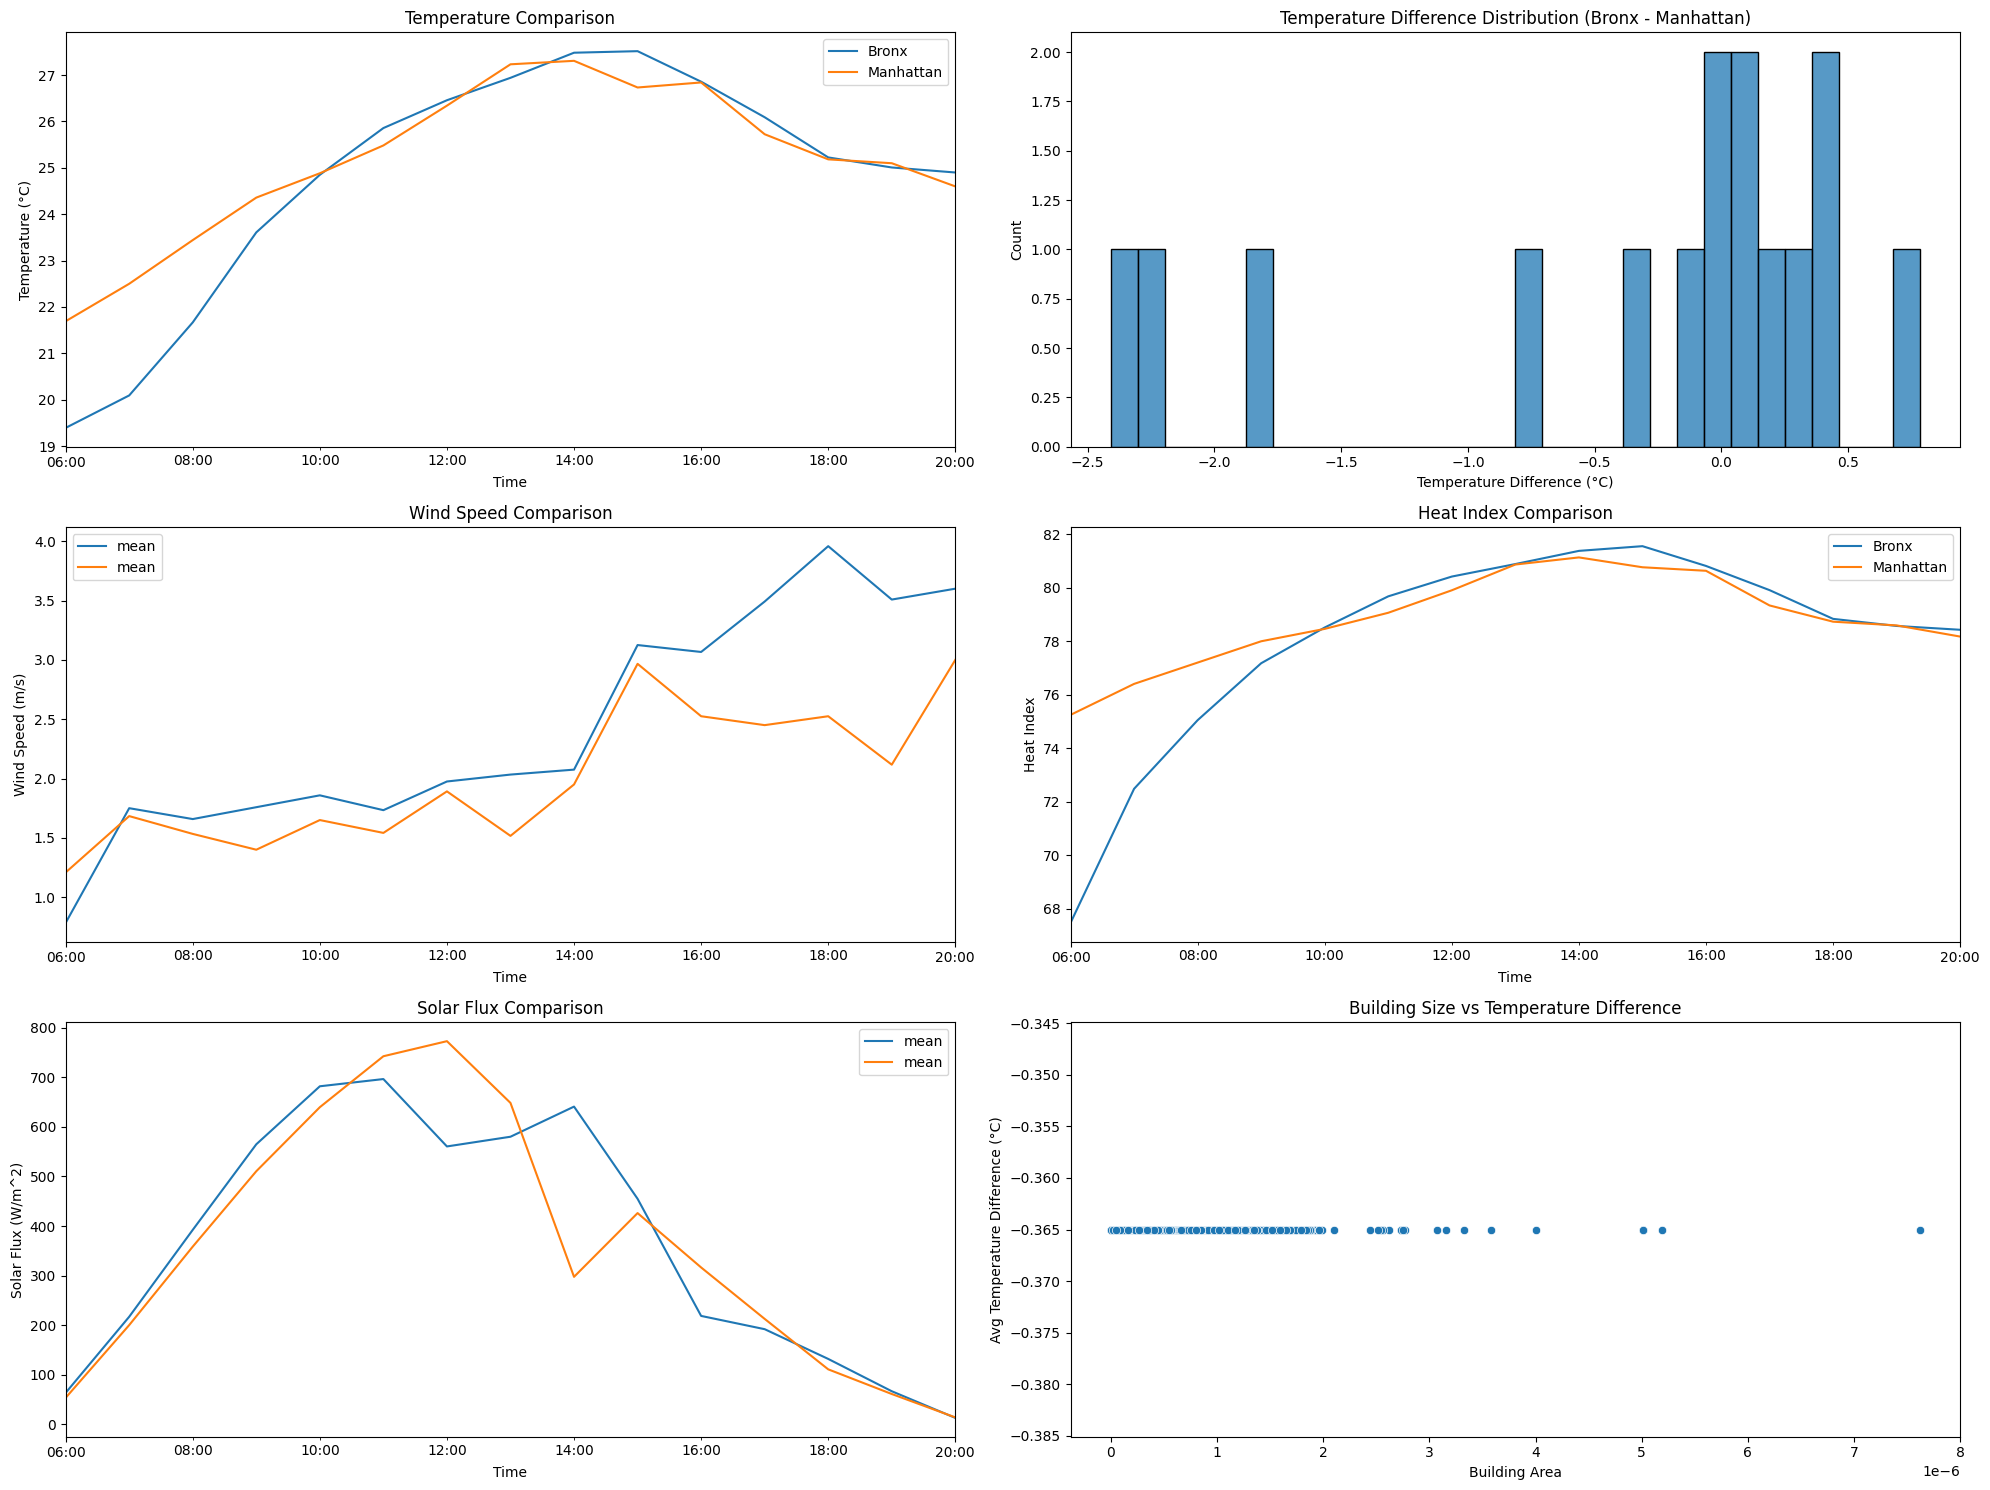

In [32]:
results = main(buildings_df, bronx_df, manhattan_df)
plt.show()  # To display the visualizations